# GANFingerprint Deepfake Detection

This notebook provides a complete walkthrough of training, evaluating, and using the GANFingerprint deepfake detection model. The model is designed to detect GAN-generated fake images by analyzing subtle fingerprint patterns in both spatial and frequency domains.

## What are GAN Fingerprints?
GAN Fingerprints are distinctive patterns or traces that are unintentionally embedded in images generated by Generative Adversarial Networks (GANs). These GAN fingerprints are akin to real human fingerprints, with the comparison that humans unintentionally leave fingerprints on the items they touch, that can be used to trace their identities. Just like human fingerprints, these GAN Fingerprints are unique to the GAN architecture the images are generated from, due to these factors:

1. Each GAN architecture has its own unique way of generating images based on its specific design, loss functions, and optimization methods.

2. Even GANs with identical architectures but different training datasets, random initializations, or hyperparameters will produce images with subtly different characteristics.

## Objective of the project

With GAN image generation images getting more advanced, there may be difficulties identifying deepfake images through existing methods, such as detecting distortions in facial features and image details. Through our project, we hope to create a deepfake detection model that can identify deepfake images reliably, no matter how realistic the generated images are to the human eye. By customizing and creating a model that can discriminate deepfake images from real ones through their GAN Fingerprint profiles, we hope to come up with a more sophisticated model which can capture details invisible to the human eye.

## 1. Setup and Dependencies

First, let's verify that we're running from the correct directory and all required files are present.

In [ ]:
# Installation cell - Run this to install all necessary dependencies
%pip install -r requirements.txt

Then, let's verify that we're running from the correct directory and all required files are present.

In [10]:
import os
import sys

# Add the current directory to the Python path
sys.path.append('.')

# Check if all required files exist
files_needed = [
    "config.py",
    "data_loader.py",
    "models/__init__.py",
    "models/fingerprint_net.py", 
    "models/layers.py",
    "train.py",
    "evaluate.py",
    "inference.py",
    "utils/metrics.py",
    "utils/experiment.py",
    "utils/visualization.py",
    "utils/reproducibility.py",
    "utils/augmentations.py"
]

missing = [f for f in files_needed if not os.path.exists(f)]
if missing:
    print("❌ Missing required files:")
    for f in missing:
        print(f"  - {f}")
    print("\nPlease run this notebook from the project root directory")
else:
    print("✅ All required files found!")

✅ All required files found!


## 2. Check Pytorch and CUDA status

In [3]:
# Check PyTorch version and CUDA availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3070 Ti Laptop GPU


## Import the necessary packages

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Import custom modules
import config
from data_loader import get_dataset_stats
from models import FingerprintNet

## 4. Display Current Configuration

The model allows for configuration of hyperparameters. The hyperparameters that led to the best results are listed below.

In [5]:
# Hyperparameters
config.LEARNING_RATE = 5e-5
config.WEIGHT_DECAY = 1e-5
config.DROPOUT_RATE = 0.40

config.DATA_ROOT = "data"  # Path to your dataset directory
config.BATCH_SIZE = 16     # Adjust based on GPU memory
config.NUM_WORKERS = 4     # Number of data loading workers
config.NUM_EPOCHS = 20     # Number of training epochs
config.EARLY_STOPPING_PATIENCE = 5 # Number of times model will run with no metrics improvement before stopping
config.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Display current configuration
print("Current Configuration:")
print(f"DATA_ROOT: {config.DATA_ROOT}")
print(f"INPUT_SIZE: {config.INPUT_SIZE}")
print(f"BACKBONE: {config.BACKBONE}")
print(f"BATCH_SIZE: {config.BATCH_SIZE}")
print(f"EARLY_STOPPING_PATIENCE: {config.EARLY_STOPPING_PATIENCE}")
print(f"LEARNING_RATE: {config.LEARNING_RATE}")
print(f"WEIGHT_DECAY: {config.WEIGHT_DECAY}")
print(f"NUM_EPOCHS: {config.NUM_EPOCHS}")
print(f"DROPOUT_RATE: {config.DROPOUT_RATE}")
print(f"DEVICE: {config.DEVICE}")
print(f"USE_AMP: {config.USE_AMP}")
print(f"CHECKPOINT_DIR: {config.CHECKPOINT_DIR}")
print(f"LOG_DIR: {config.LOG_DIR}")

Current Configuration:
DATA_ROOT: data
INPUT_SIZE: 256
BACKBONE: resnet34
BATCH_SIZE: 16
EARLY_STOPPING_PATIENCE: 5
LEARNING_RATE: 5e-05
WEIGHT_DECAY: 1e-05
NUM_EPOCHS: 20
DROPOUT_RATE: 0.4
DEVICE: cuda
USE_AMP: True
CHECKPOINT_DIR: checkpoints
LOG_DIR: logs


## 6. Check Dataset Structure

In [6]:
# Check dataset structure
def check_dataset_structure():
    paths = [
        config.TRAIN_REAL_DIR,
        config.TRAIN_FAKE_DIR,
        config.VAL_REAL_DIR,
        config.VAL_FAKE_DIR,
        config.TEST_REAL_DIR,
        config.TEST_FAKE_DIR
    ]
    
    for path in paths:
        if not os.path.exists(path):
            print(f"❌ {path} does not exist!")
        else:
            print(f"✅ {path} exists with {len(os.listdir(path))} images")

check_dataset_structure()
get_dataset_stats()

✅ data\train/real exists with 70001 images
✅ data\train/fake exists with 70001 images
✅ data\validation/real exists with 19787 images
✅ data\validation/fake exists with 19641 images
✅ data\test/real exists with 5413 images
✅ data\test/fake exists with 5492 images
Dataset Statistics:
Train: 70001 real, 70001 fake
Validation: 19787 real, 19641 fake
Test: 5413 real, 5492 fake


## 7. Display Sample Images

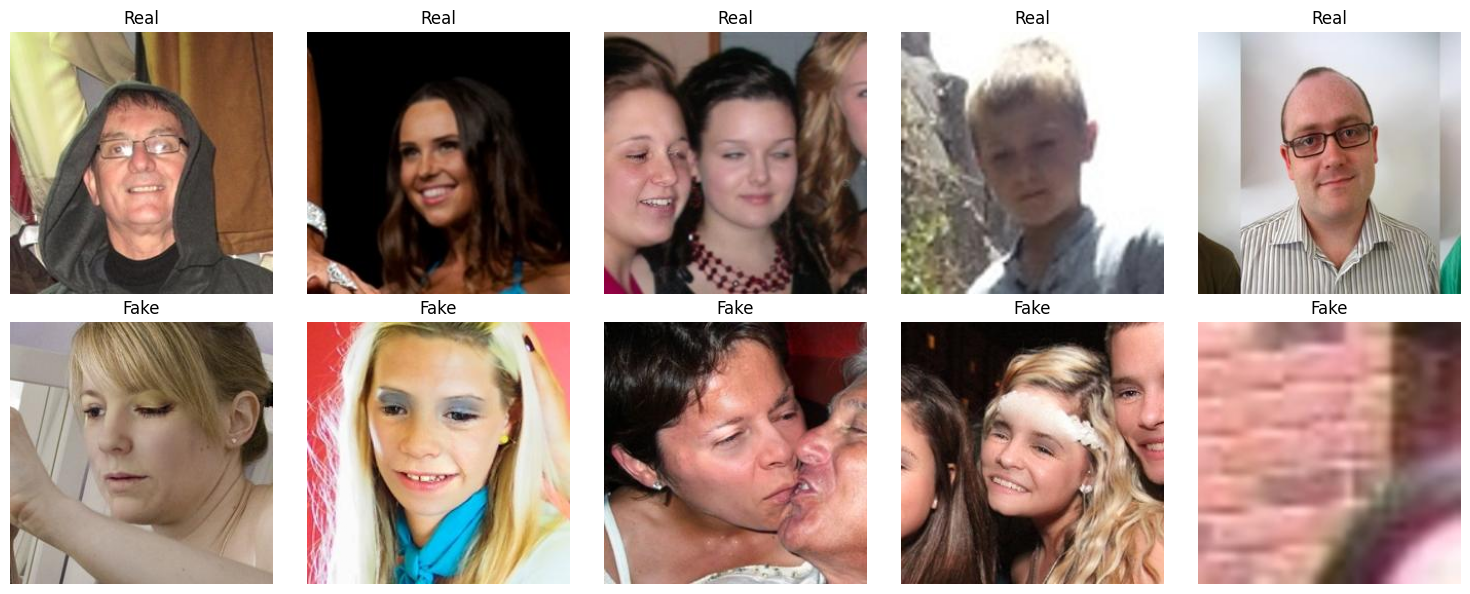

In [7]:
# Display some sample images from the dataset
def show_samples(real_dir, fake_dir, n=5):
    transform = transforms.Compose([
        transforms.Resize(config.INPUT_SIZE),
        transforms.CenterCrop(config.INPUT_SIZE),
        transforms.ToTensor()
    ])
    
    # Check if directories exist
    if not os.path.exists(real_dir) or not os.path.exists(fake_dir):
        print(f"Error: One or more directories do not exist:\n{real_dir}\n{fake_dir}")
        return
    
    # Get image lists
    real_files = os.listdir(real_dir)
    fake_files = os.listdir(fake_dir)
    
    if not real_files or not fake_files:
        print("Error: One or more directories are empty")
        return
    
    real_images = [os.path.join(real_dir, f) for f in real_files[:n]]
    fake_images = [os.path.join(fake_dir, f) for f in fake_files[:n]]
    
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(real_images + fake_images):
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)
        
        plt.subplot(2, n, i + 1)
        plt.imshow(img_tensor.permute(1, 2, 0))
        plt.title("Real" if i < n else "Fake")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show samples from training set
try:
    show_samples(config.TRAIN_REAL_DIR, config.TRAIN_FAKE_DIR)
except Exception as e:
    print(f"Error displaying samples: {e}")

## 8. Initialize the model with overview of trainable paramaters

In [8]:
# Initialize the model
model = FingerprintNet(backbone=config.BACKBONE)
model = model.to(config.DEVICE)

# Count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print model architecture summary
print(model)
print(f"Total trainable parameters: {count_parameters(model):,}")

FingerprintNet(
  (backbone_low): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

## 9. Training the model

In [9]:
from train import train as train_function

# Wrapper for the training function
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

def train_model(data_root=config.DATA_ROOT, 
                batch_size=config.BATCH_SIZE, 
                lr=config.LEARNING_RATE, 
                epochs=config.NUM_EPOCHS, 
                backbone=config.BACKBONE,
                no_amp=not config.USE_AMP, 
                resume_checkpoint=None):
    
    # Override config values if needed
    config.DATA_ROOT = data_root
    config.BATCH_SIZE = batch_size
    config.LEARNING_RATE = lr
    config.NUM_EPOCHS = epochs
    config.BACKBONE = backbone
    config.USE_AMP = not no_amp
    
    # Create args object
    args = Args(
        data_root=data_root,
        batch_size=batch_size,
        lr=lr,
        epochs=epochs,
        backbone=backbone,
        no_amp=no_amp,
        resume_checkpoint=resume_checkpoint
    )
    
    # Call the training function
    train_function(args)
    
    # Return the path to the best checkpoint
    return os.path.join(config.CHECKPOINT_DIR, f"ganfingerprint_best.pth")

# Train the model 
best_checkpoint = train_model()

# To resume training from a checkpoint (uncomment to run):
# best_checkpoint = train_model(resume_checkpoint="checkpoints/ganfingerprint_epoch10.pth")

All seeds set to 42 for reproducibility
Directory exists (CHECKPOINT_DIR): True
Directory exists (LOG_DIR): True
Directory exists (EXPERIMENT_LOGS): False
Created experiment directory: c:\Users\chowl\OneDrive\Documents\Documents\Homework stuff\Term 6\Applied Deep Learning\Project\deepfake-detection-LZ-GANFingerprint\experiment_logs\ganfingerprint_20250415_102944_20250415_102953
Experiment tracker initialized at c:\Users\chowl\OneDrive\Documents\Documents\Homework stuff\Term 6\Applied Deep Learning\Project\deepfake-detection-LZ-GANFingerprint\experiment_logs\ganfingerprint_20250415_102944_20250415_102953
Starting training with configuration:
Configuration saved to c:\Users\chowl\OneDrive\Documents\Documents\Homework stuff\Term 6\Applied Deep Learning\Project\deepfake-detection-LZ-GANFingerprint\experiment_logs\ganfingerprint_20250415_102944_20250415_102953\config.json
Using device: cuda
Dataset Statistics:
Train: 70001 real, 70001 fake
Validation: 19787 real, 19641 fake
Test: 5413 real,

Epoch 1/20 [Train]:   0%|          | 0/8750 [00:00<?, ?it/s]c:\Users\chowl\OneDrive\Documents\Documents\Homework stuff\Term 6\Applied Deep Learning\Project\deepfake-detection-LZ-GANFingerprint\deepfake_env\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:96.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/20 [Train]:   1%|          | 46/8750 [00:25<1:19:17,  1.83it/s, loss=0.6944]


KeyboardInterrupt: 

## 10. Evaluating the trained model

<>:33: SyntaxWarning: invalid escape sequence '\R'
<>:33: SyntaxWarning: invalid escape sequence '\R'
C:\Users\chowl\AppData\Local\Temp\ipykernel_29376\3725611716.py:33: SyntaxWarning: invalid escape sequence '\R'
  evaluate_model("checkpoints\Run_19_learning_rate_0.00005\ganfingerprint_20250411_125832_best.pth")


All seeds set to 42 for reproducibility
Loading checkpoint from checkpoints\Run_19_learning_rate_0.00005\ganfingerprint_20250411_125832_best.pth
Could not restore random state - using default seed
All seeds set to 42 for reproducibility


Evaluating: 100%|██████████| 682/682 [00:32<00:00, 20.76it/s]


Test Set Metrics:
Accuracy: 0.9476
Precision: 0.9546
Recall: 0.9392
F1-Score: 0.9468
AUC-ROC: 0.9890
Evaluation results saved to eval_results


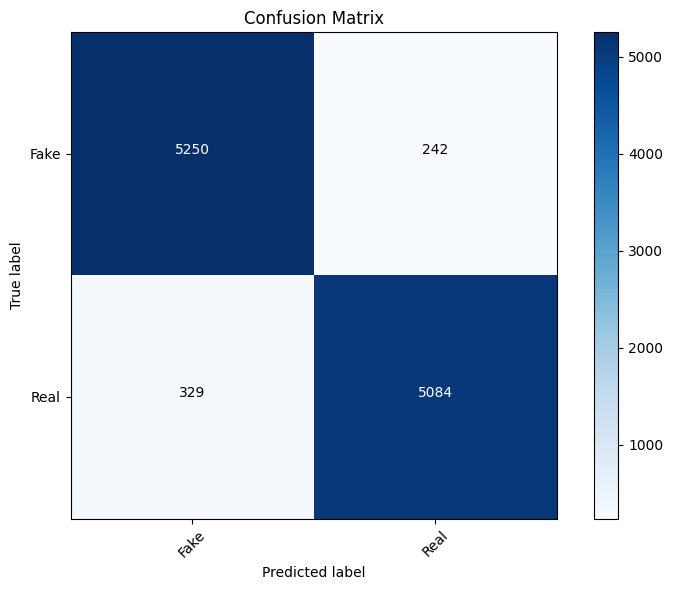

<Figure size 800x600 with 0 Axes>

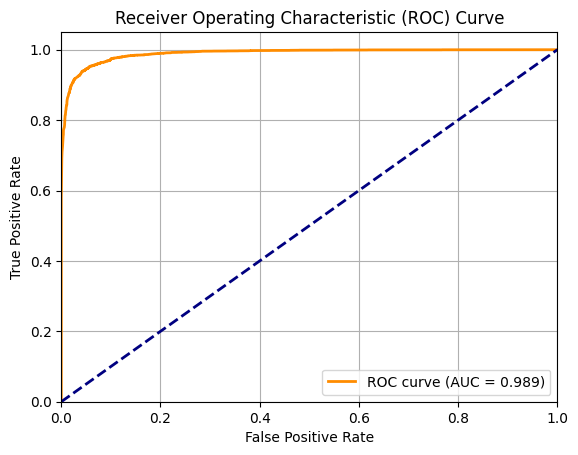

<Figure size 800x600 with 0 Axes>

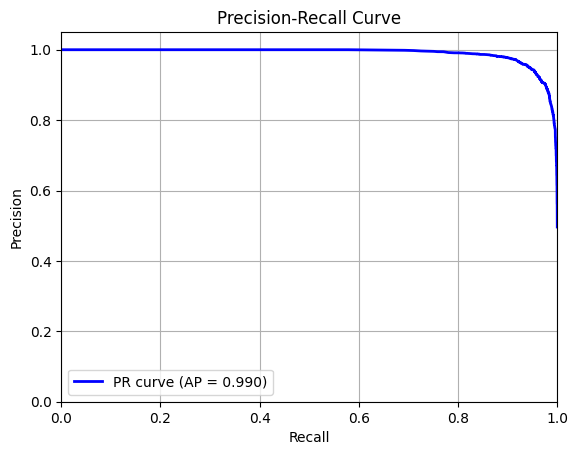

In [ ]:
from evaluate import evaluate as evaluate_function

# Wrapper for the evaluation function
def evaluate_model(checkpoint_path, output_dir="eval_results"):
    """
    Evaluate the model on the test set.
    
    Args:
        checkpoint_path: Path to the model checkpoint
        output_dir: Directory to save evaluation results
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Call the evaluation function
    evaluate_function(checkpoint_path, output_dir)
        
    # Display the generated images
    image_paths = [
        os.path.join(output_dir, "confusion_matrix.png"),
        os.path.join(output_dir, "roc_curve.png"),
        os.path.join(output_dir, "precision_recall_curve.png")
    ]
    

# Evaluate the model (Insert relative directory to trained model in checkpoints folder to run the evaluation)
evaluate_model("checkpoints\Run_19_learning_rate_0.00005\ganfingerprint_20250411_125832_best.pth")

## 11. Testing the model with actual images

After training and evaluating the model, we can try out the capabilities of the model by having it classify any image that is outside of the dataset. Lets see if it is able to classify images correctly!

### Single image inference

<>:25: SyntaxWarning: invalid escape sequence '\R'
<>:25: SyntaxWarning: invalid escape sequence '\R'
C:\Users\chowl\AppData\Local\Temp\ipykernel_29376\66404838.py:25: SyntaxWarning: invalid escape sequence '\R'
  model_checkpoint = "checkpoints\Run_19_learning_rate_0.00005\Ganfingerprint_20250411_125832_best.pth"


All seeds set to 42 for reproducibility
Raw logit: -10.953125, Original prob: 0.000018, Calibrated: 0.999965
Prediction for fake_23.jpg: Fake (Confidence: 1.0000)


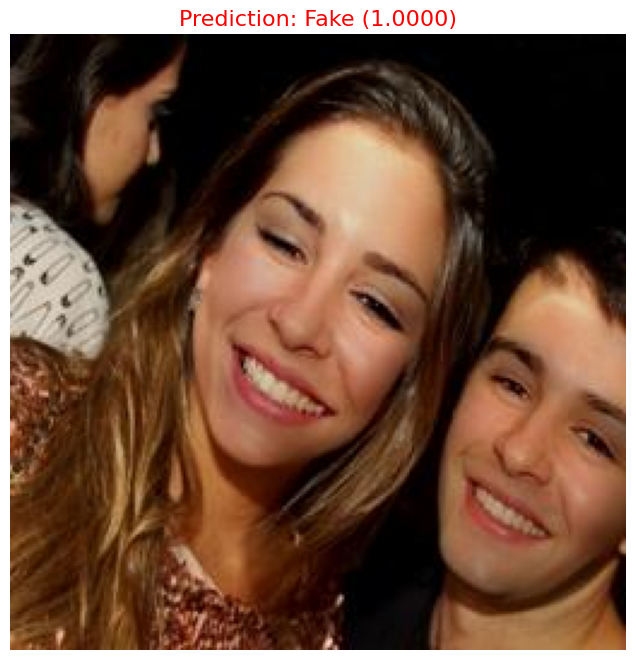

In [21]:
import torch.serialization
import os
from inference import run_inference

# Add numpy scalar to safe globals for PyTorch 2.6+ compatibility
torch.serialization.add_safe_globals(['numpy._core.multiarray.scalar'])

# Function to run single image inference
def run_single_inference(checkpoint_path, image_path, output_dir=None):
    """
    Run inference on a single image using functions from inference.py
    """
    # Fix path separators if needed
    checkpoint_path = checkpoint_path.replace('\\', '/')
    image_path = image_path.replace('\\', '/')
    if output_dir:
        output_dir = output_dir.replace('\\', '/')
        os.makedirs(output_dir, exist_ok=True)
    
    # Run inference
    print(f"Running inference on: {image_path}")
    print(f"Using checkpoint: {checkpoint_path}")
    run_inference(checkpoint_path, image_path, output_dir, batch_mode=False)

model_checkpoint = "checkpoints\Run_19_learning_rate_0.00005\Ganfingerprint_20250411_125832_best.pth"
test_image_path =  "data/test/fake/fake_23.jpg"

run_inference(model_checkpoint, test_image_path)

### Batch Inference

In [ ]:
def run_batch_inference(checkpoint_path, image_dir, output_dir="inference_results"):
    """
    Run inference on a directory of images using functions from inference.py
    """
    # Fix path separators if needed
    checkpoint_path = checkpoint_path.replace('\\', '/')
    image_dir = image_dir.replace('\\', '/')
    output_dir = output_dir.replace('\\', '/')
    os.makedirs(output_dir, exist_ok=True)
    
    # Run inference
    print(f"Running batch inference on directory: {image_dir}")
    print(f"Using checkpoint: {checkpoint_path}")
    run_inference(checkpoint_path, image_dir, output_dir, batch_mode=True)

# Run inference on a single image (uncomment to run)
test_image_path = "test_images/fake_21.jpg"
checkpoint_path = "checkpoints/Run_19_learning_rate_0.00005/ganfingerprint_20250411_125832_best.pth"
run_single_inference(checkpoint_path, test_image_path, "inference_results")

# Run inference on a directory of images (uncomment to run)
# test_dir = "test_images"
# run_batch_inference(checkpoint_path, test_dir, "inference_results")

# Interactive Demo

In [15]:
# # Interactive image upload and prediction (using ipywidgets)
# from ipywidgets import FileUpload, Button, Output, HBox, VBox, HTML
# from IPython.display import display, clear_output
# import io

# def create_interactive_demo(checkpoint_path):
#     # Load model
#     model = FingerprintNet(backbone=config.BACKBONE)
#     checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE, weights_only=False)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model = model.to(config.DEVICE)
#     model.eval()
    
#     # Transform for inference
#     transform = transforms.Compose([
#         transforms.Resize(config.INPUT_SIZE),
#         transforms.CenterCrop(config.INPUT_SIZE),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])
    
#     # Create widgets
#     file_upload = FileUpload(accept='image/*', multiple=False)
#     predict_button = Button(description='Predict')
#     output = Output()
    
#     # Define button click handler
#     def on_predict_button_clicked(b):
#         with output:
#             clear_output()
            
#             if not file_upload.value:
#                 print("Please upload an image first.")
#                 return
            
#             # Get the uploaded file
#             uploaded_file = list(file_upload.value.values())[0]
#             content = uploaded_file['content']
            
#             # Convert to PIL Image
#             image = Image.open(io.BytesIO(content)).convert('RGB')
            
#             # Preprocess and make prediction
#             image_tensor = transform(image).unsqueeze(0).to(config.DEVICE)
            
#             with torch.no_grad():
#                 if config.USE_AMP:
#                     with torch.cuda.amp.autocast():
#                         output = model(image_tensor)
#                 else:
#                     output = model(image_tensor)
            
#             # Get probability and class
#             prob = torch.sigmoid(output).item()
#             pred_class = "Real" if prob >= 0.5 else "Fake"
            
#             # Display results
#             color = 'green' if pred_class == 'Real' else 'red'
#             display(HTML(f"<h3 style='color:{color}'>Prediction: {pred_class} (Confidence: {prob:.4f})</h3>"))
            
#             # Display image
#             plt.figure(figsize=(8, 8))
#             plt.imshow(image)
#             plt.axis('off')
#             plt.title(f"Prediction: {pred_class} ({prob:.4f})", color=color, fontsize=16)
#             plt.show()
    
#     # Connect the button click event
#     predict_button.on_click(on_predict_button_clicked)
    
#     # Create UI layout
#     display(HTML("<h2>Deepfake Detection Demo</h2>"))
#     display(HTML("<p>Upload an image and click 'Predict' to detect if it's real or a GAN-generated fake.</p>"))
#     display(HBox([file_upload, predict_button]))
#     display(output)

# # Run the interactive demo (uncomment to run)
# create_interactive_demo("checkpoints\Run_19_learning_rate_0.00005\ganfingerprint_20250411_125832_best.pth")